### Lesson 4

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

#### скачать набор данных маркетинговых кампаний. поле conversion - это целевая переменная, а offer - коммуникация.

In [2]:
# Чтение данных
df = pd.read_csv('data.csv')
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


#### переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
df.loc[df['offer'] == 'No Offer', 'offer'] = 0
df.loc[df['offer'] != 0, 'offer'] = 1
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'] = pd.to_numeric(df['treatment'])

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


#### сделать feature engineering

In [4]:
# Ищем пропущенные значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [5]:
# Проверяем типы данных
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [6]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [7]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [8]:
# Заменим номинативные переменные на ранговые
ch = df['channel'].value_counts().index
for n, el in enumerate(ch):
    print(el, n)
    df.loc[df['channel'] == el, 'channel'] = n
ch = df['zip_code'].value_counts().index
for n, el in enumerate(ch):
    print(el, n)
    df.loc[df['zip_code'] == el, 'zip_code'] = n
df

Web 0
Phone 1
Multichannel 2
Surburban 0
Urban 1
Rural 2


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,0,0,1,1,0
1,6,329.08,1,1,2,1,0,0,0
2,7,180.65,0,1,0,1,0,1,0
3,9,675.83,1,0,2,1,0,1,0
4,2,45.34,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,1,0,0,1,0
63996,5,38.91,0,1,1,1,1,1,0
63997,6,29.99,1,0,1,1,1,1,0
63998,1,552.94,1,0,0,1,2,1,0


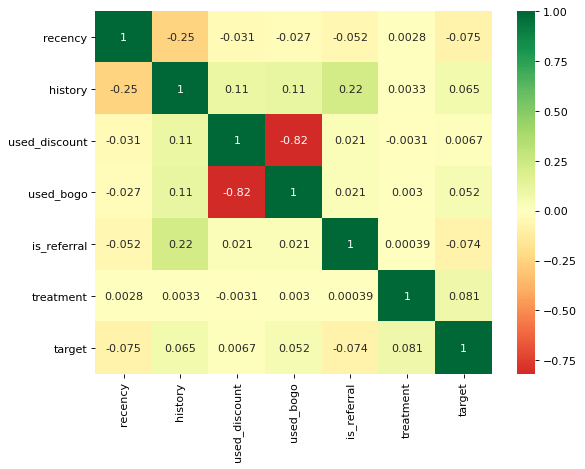

In [9]:
# Проверяем на мультиколлинеарность
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

#### Наблюдается обратная корреляция между used_discount и used_bogo, возможно стоит исключить used_discount из модели во избежании мультиколлинеарности. Выбор used_discount связан с тем что ее линейная взаимосвязь с recency выще чем у used_bogo

#### сделать разбиение набора данных на тренировочную и тестовую выборки

In [10]:
indices = df.index
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'])
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
8427,7,879.00,1,0,1,1,2,0
37298,8,536.28,0,1,1,1,2,1
13772,1,520.51,1,0,0,1,2,1
63955,1,29.99,1,0,0,0,1,1
61721,10,30.86,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...
17446,8,92.18,1,0,1,0,0,0
26372,10,97.34,1,0,0,0,1,1
31882,2,241.76,1,0,2,0,1,1
46972,9,220.22,0,1,1,1,2,1


In [11]:
treat_train = X_train['treatment']
treat_test=  X_test['treatment']
treat_train_full = df['treatment']

In [12]:
treat_train_full

0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment, Length: 64000, dtype: int64

In [13]:
cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [14]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)


In [15]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-15-79ef78f5bad7>:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [16]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

#### в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [17]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.102158,0.080858
1,ClassTransformation,0.273813,0.222133
2,TwoModels,0.075000,0.069604


#### построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [18]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)

X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

Wall time: 34 s


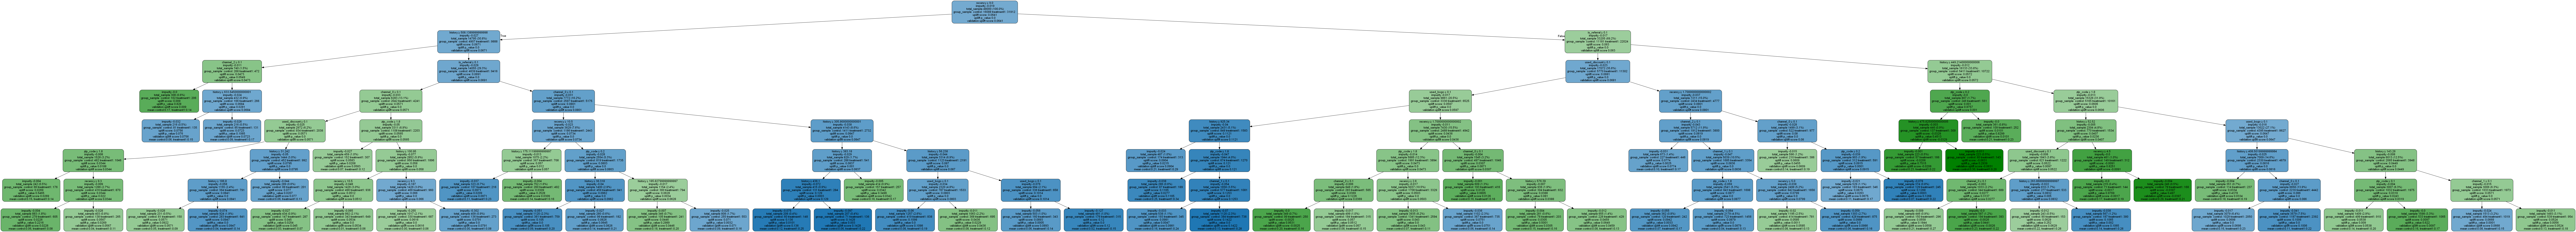

In [19]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())